##### 21BDS0340 - Abhinav Dinesh Srivatsa

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv", header=None)
test = pd.read_csv("test.csv", header=None)
train.columns = ["Score", "Review"]
test.columns = train.columns
train

,Score,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [3]:
# selecting random 1% of data due to large data size
reviews = train["Review"].values
ratings = (train["Score"] - 1).values

np.random.seed(42)
sample_size = int(0.01 * len(reviews))
random_indices = np.random.choice(len(reviews), size=sample_size, replace=False)

sampled_reviews = reviews[random_indices]
sampled_ratings = ratings[random_indices]

reviews

array(["Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",
       "Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understan

In [4]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(reviews)
vocab = encoder.get_vocabulary()
vocab

2024-10-02 16:07:21.346933: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-02 16:07:21.346959: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-02 16:07:21.346964: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-02 16:07:21.347003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-02 16:07:21.347016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-02 16:07:21.511610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


['',
 '[UNK]',
 'the',
 'and',
 'i',
 'to',
 'a',
 'was',
 'of',
 'it',
 'for',
 'in',
 'is',
 'that',
 'my',
 'we',
 'this',
 'with',
 'but',
 'they',
 'you',
 'on',
 'not',
 'have',
 'had',
 'at',
 'were',
 'so',
 'are',
 'be',
 'food',
 'place',
 'me',
 'there',
 'as',
 'good',
 'out',
 'like',
 'if',
 'all',
 'just',
 'our',
 'very',
 'get',
 'one',
 'here',
 'when',
 'its',
 'from',
 'time',
 'or',
 'up',
 'would',
 'great',
 'service',
 'their',
 'about',
 'back',
 'no',
 'go',
 'an',
 'what',
 'really',
 'he',
 'she',
 'will',
 'which',
 'some',
 'been',
 'only',
 'us',
 'your',
 'because',
 'dont',
 'even',
 'more',
 'can',
 'by',
 'them',
 'got',
 'other',
 'after',
 'do',
 'didnt',
 'also',
 'im',
 'too',
 'never',
 'ordered',
 'did',
 'has',
 'nice',
 'well',
 'went',
 'than',
 'could',
 'order',
 'then',
 'came',
 'people',
 'over',
 'much',
 'first',
 'said',
 'restaurant',
 'ive',
 'her',
 'little',
 'best',
 'know',
 'off',
 'again',
 'better',
 'going',
 'how',
 'who',


In [5]:
encoded = encoder(sampled_reviews)
encoded

<tf.Tensor: shape=(5600, 979), dtype=int64, numpy=
array([[ 16,  31,  12, ...,   0,   0,   0],
       [  2, 152,  49, ...,   0,   0,   0],
       [  4,  89,  22, ...,   0,   0,   0],
       ...,
       [  1, 413,  36, ...,   0,   0,   0],
       [  4, 241,  37, ...,   0,   0,   0],
       [ 24, 314,  45, ...,   0,   0,   0]])>

In [9]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(sampled_reviews, sampled_ratings, epochs=5, validation_split=0.2)

Epoch 1/5


2024-10-02 16:13:00.842093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:13:01.886003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:13:02.068467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:13:02.452735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:13:02.643069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:13:03.357863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:13:03.592013: I tensorflow/core/grappler/optimizers/cust

140/140 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5069

2024-10-02 16:14:16.860701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:14:17.452221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:14:17.559372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:14:17.961393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-02 16:14:18.067883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 92s 600ms/step - loss: 0.6937 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.5098
Epoch 2/5
140/140 [==============================] - 81s 577ms/step - loss: 0.6923 - accuracy: 0.5089 - val_loss: 0.6944 - val_accuracy: 0.4955
Epoch 3/5
140/140 [==============================] - 86s 613ms/step - loss: 0.6922 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4946
Epoch 4/5
140/140 [==============================] - 83s 592ms/step - loss: 0.6924 - accuracy: 0.5000 - val_loss: 0.7025 - val_accuracy: 0.4982
Epoch 5/5
140/140 [==============================] - 75s 536ms/step - loss: 0.6871 - accuracy: 0.5013 - val_loss: 0.7007 - val_accuracy: 0.5116


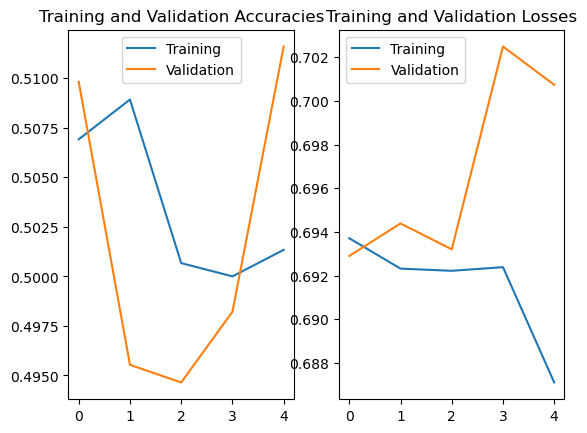

In [12]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title("Training and Validation Accuracies")
plt.legend(["Training", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title("Training and Validation Losses")
plt.legend(["Training", "Validation"])

In [14]:
text = "Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
pred = model.predict([text])
pred[0][0]

1/1 [==============================] - 1s 707ms/step


0.026581043